In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
bart = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/bart.csv')

In [3]:
bart.head()

,date,passenger
0,2017-01-01,122773
1,2017-01-02,139245
2,2017-01-03,366495
3,2017-01-04,388842
4,2017-01-05,407099


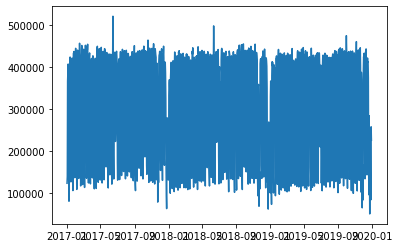

In [4]:
bart['date'] = pd.to_datetime(bart['date'])
plt.plot(bart['date'],bart['passenger'])

In [6]:
lm = sm.OLS(bart['passenger'], sm.add_constant(bart.index)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.272
Date:                Mon, 13 Jun 2022   Prob (F-statistic):              0.132
Time:                        19:05:06   Log-Likelihood:                -14433.
No. Observations:                1095   AIC:                         2.887e+04
Df Residuals:                    1093   BIC:                         2.888e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.407e+05   7754.413     43.936      0.0

In [7]:
# p value greater than 5 percent trend not statistically significant

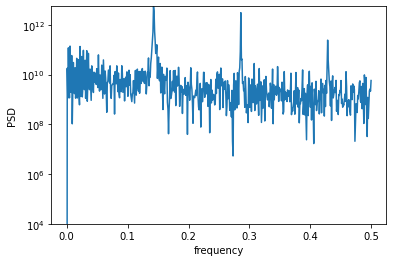

In [9]:
f, PSD = scipy.signal.periodogram(bart.passenger, 1)
plt.semilogy(f,PSD)
plt.xlabel('frequency')
plt.ylabel('PSD')
plt.ylim(10**4, max(PSD))
plt.show()

In [10]:
# periodogram shows that strngest period detected at frequency 1/7

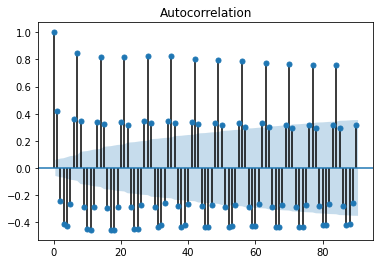

In [14]:
plot_acf(bart.passenger, lags =90);

In [15]:
# Autocorrelation peaks also corresponfing weekly change

In [16]:
bart['DOW'] = bart['date'].dt.dayofweek

In [17]:
bart.head()

,date,passenger,DOW
0,2017-01-01,122773,6
1,2017-01-02,139245,0
2,2017-01-03,366495,1
3,2017-01-04,388842,2
4,2017-01-05,407099,3


In [31]:
X = pd.concat([pd.DataFrame(range(730),columns=['day']),
               pd.get_dummies(bart['DOW'],drop_first=False)[:730].reset_index(drop=True)],axis=1)

In [32]:
X

,day,0,1,2,3,4,5,6
0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0
2,2,0,1,0,0,0,0,0
3,3,0,0,1,0,0,0,0
4,4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
725,725,0,0,0,1,0,0,0
726,726,0,0,0,0,1,0,0
727,727,0,0,0,0,0,1,0
728,728,0,0,0,0,0,0,1


In [20]:
lm = sm.OLS(bart.passenger[:730], X).fit()

In [21]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     512.6
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          3.58e-275
Time:                        19:31:39   Log-Likelihood:                -8961.8
No. Observations:                 730   AIC:                         1.794e+04
Df Residuals:                     722   BIC:                         1.798e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day          -22.1202      9.170     -2.412      0.0

In [22]:
# affected by all days

<BarContainer object of 7 artists>

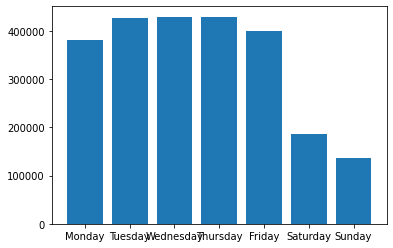

In [30]:
plt.bar(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], lm.params[1:].tolist())

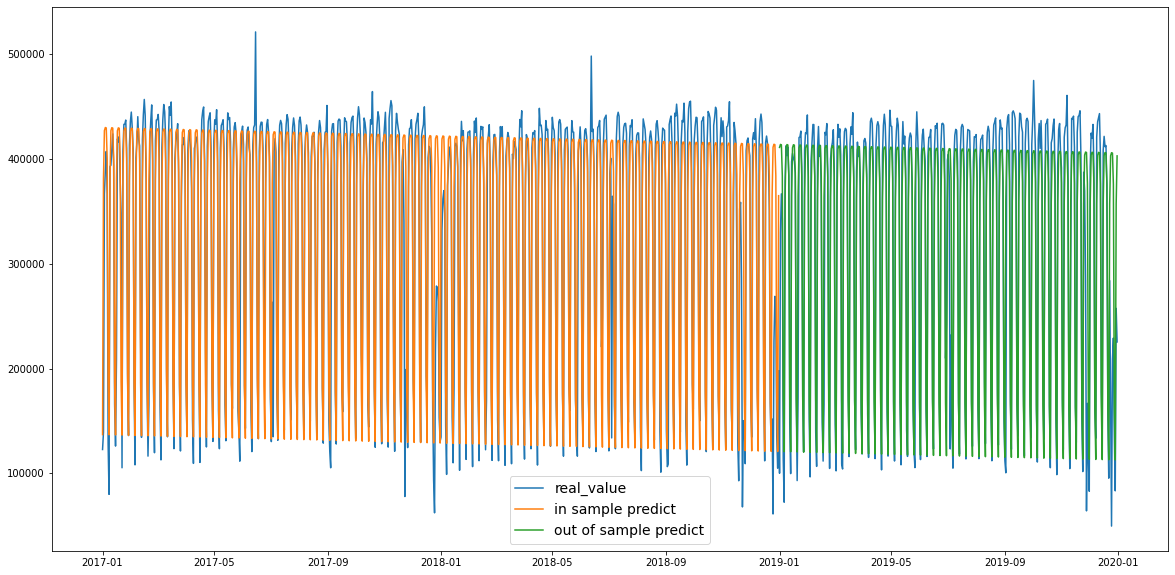

In [33]:
plt.figure(figsize = (20,10))
plt.subplot(111)

plt.plot(bart.date, bart.passenger, label = 'real_value')
inSample = lm.predict(X)

X = pd.concat([pd.DataFrame(range(730,len(bart)),columns=['day']),
               pd.get_dummies(bart['DOW'][730:],drop_first=False).reset_index(drop=True)],axis=1)
#X = sm.add_constant(X)
outofSample = lm.predict(X)

plt.plot(bart.date[:730],inSample,label='in sample predict')
plt.plot(bart.date[730:],outofSample,label='out of sample predict')
plt.legend(fontsize=14)

In [35]:
print('in sample R^2:',r2_score(bart['passenger'][:730],inSample))
print('out of sample R^2:',r2_score(bart['passenger'][730:],outofSample))

in sample R^2: 0.8324941917707158
out of sample R^2: 0.8203089387540559


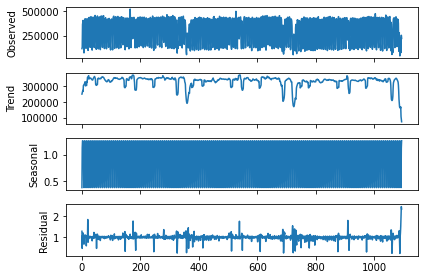

In [37]:
daySeries = bart['passenger']
dailyDecomp = seasonal_decompose(daySeries, model = 'multiplicative', freq = 7, extrapolate_trend='freq')
fig = dailyDecomp.plot()

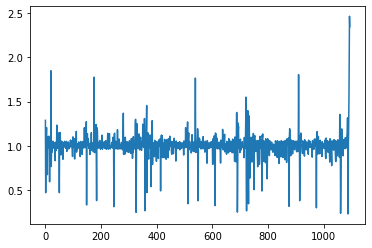

In [38]:
bartResid = dailyDecomp.resid 
plt.plot(bartResid)

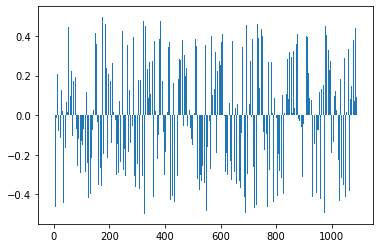

In [39]:
outlierData = pd.DataFrame({})
outlierData['Res'] = bartResid
outlierData['Percentile_rank'] = outlierData.Res.rank(pct = True)-0.5
plt.bar(np.arange(0, len(outlierData)), outlierData['Percentile_rank'])
plt.show()

In [40]:

bart.date[outlierData['Percentile_rank']>0.475]

0      2017-01-01
20     2017-01-21
147    2017-05-28
175    2017-06-25
280    2017-10-08
324    2017-11-21
356    2017-12-23
363    2017-12-30
364    2017-12-31
384    2018-01-20
511    2018-05-27
539    2018-06-24
687    2018-11-19
688    2018-11-20
692    2018-11-24
720    2018-12-22
721    2018-12-23
727    2018-12-29
728    2018-12-30
732    2019-01-03
910    2019-06-30
1058   2019-11-25
1059   2019-11-26
1086   2019-12-23
1091   2019-12-28
1092   2019-12-29
1093   2019-12-30
1094   2019-12-31
Name: date, dtype: datetime64[ns]

In [41]:
bart.date[outlierData['Percentile_rank']<-0.475]

1      2017-01-02
15     2017-01-16
50     2017-02-20
148    2017-05-29
184    2017-07-04
246    2017-09-04
326    2017-11-23
358    2017-12-25
365    2018-01-01
379    2018-01-15
414    2018-02-19
512    2018-05-28
549    2018-07-04
610    2018-09-03
690    2018-11-22
691    2018-11-23
723    2018-12-25
730    2019-01-01
735    2019-01-06
750    2019-01-21
778    2019-02-18
797    2019-03-09
876    2019-05-27
914    2019-07-04
974    2019-09-02
1061   2019-11-28
1088   2019-12-25
Name: date, dtype: datetime64[ns]